In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Dacia.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_1310,Seri_Jogger,Seri_Lodgy,...,Model_1.6 MCV Black Line,Model_1.6 SCE Eco-G Ambiance,Model_1.6 Stepway,Model_L,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,565999,2017,90,898,95000,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,285000,2009,70,1461,260000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,435000,2016,90,1461,170000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,645000,2020,110,1598,79450,0.0,1.0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
4,447000,2014,90,1461,221000,2.0,1.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_16960\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,46375.853002,2.960256e+09,54408.237157,36655.451464


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:09:47,002] A new study created in memory with name: no-name-a3195874-2a23-4759-b0dc-e504f946c71c
[I 2023-10-08 14:09:47,137] Trial 0 finished with value: 421611.3283350443 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.0041641011955286834, 'max_depth': 10, 'min_child_weight': 110}. Best is trial 0 with value: 421611.3283350443.
[I 2023-10-08 14:09:47,141] Trial 5 finished with value: 437734.5628989986 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.00014933699988703156, 'max_depth': 10, 'min_child_weight': 272}. Best is trial 0 with value: 421611.3283350443.
[I 2023-10-08 14:09:47,153] Trial 1 finished with value: 437723.445413816 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.0001449888150007643, 'max_depth': 15, 'min_child_weight': 292}. Best is trial 0 with value: 421611.3283350443.
[I 2023-10-08 14:09:47,175] Trial 6 finished with value: 429696.52106089593 and parameters:

[I 2023-10-08 14:09:48,389] Trial 30 finished with value: 140702.8810593157 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.13110115379847773, 'max_depth': 7, 'min_child_weight': 170}. Best is trial 26 with value: 68996.52694568614.
[I 2023-10-08 14:09:48,405] Trial 31 finished with value: 147176.42100066147 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.11896107033058477, 'max_depth': 7, 'min_child_weight': 178}. Best is trial 26 with value: 68996.52694568614.
[I 2023-10-08 14:09:48,469] Trial 32 finished with value: 133579.79045468612 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.13808203404286895, 'max_depth': 7, 'min_child_weight': 164}. Best is trial 26 with value: 68996.52694568614.
[I 2023-10-08 14:09:48,541] Trial 33 finished with value: 147948.2135392923 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.12111331763935428, 'max_depth': 15, 'min_child_weig

[I 2023-10-08 14:09:50,139] Trial 61 finished with value: 52857.49663831231 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.49787983510294986, 'max_depth': 12, 'min_child_weight': 30}. Best is trial 61 with value: 52857.49663831231.
[I 2023-10-08 14:09:50,147] Trial 60 finished with value: 53245.83156865899 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.49437903182826765, 'max_depth': 12, 'min_child_weight': 26}. Best is trial 61 with value: 52857.49663831231.
[I 2023-10-08 14:09:50,186] Trial 62 finished with value: 192367.42639640943 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.08384398445294114, 'max_depth': 12, 'min_child_weight': 27}. Best is trial 61 with value: 52857.49663831231.
[I 2023-10-08 14:09:50,217] Trial 65 finished with value: 56826.141067137614 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.2596833237760697, 'max_depth': 12, 'min_child_weigh

[I 2023-10-08 14:09:51,973] Trial 90 finished with value: 52567.06906148109 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.3416691984469313, 'max_depth': 9, 'min_child_weight': 41}. Best is trial 70 with value: 49596.30379467933.
[I 2023-10-08 14:09:51,997] Trial 91 finished with value: 54828.75004513901 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.28311097436434934, 'max_depth': 9, 'min_child_weight': 38}. Best is trial 70 with value: 49596.30379467933.
[I 2023-10-08 14:09:52,187] Trial 92 finished with value: 58603.40753007177 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.2694125774076065, 'max_depth': 10, 'min_child_weight': 39}. Best is trial 70 with value: 49596.30379467933.
[I 2023-10-08 14:09:52,284] Trial 93 finished with value: 53898.01999802585 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.2759253945408522, 'max_depth': 10, 'min_child_weight': 7}

[I 2023-10-08 14:09:54,047] Trial 119 finished with value: 50801.53325138526 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4053063449257928, 'max_depth': 11, 'min_child_weight': 26}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:09:54,156] Trial 121 finished with value: 63351.81458336376 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.22689546567314361, 'max_depth': 11, 'min_child_weight': 24}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:09:54,169] Trial 123 finished with value: 61879.3644367986 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.23085896509795958, 'max_depth': 11, 'min_child_weight': 25}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:09:54,205] Trial 122 finished with value: 63185.279015483975 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.22752543911910947, 'max_depth': 11, 'min_child_wei

[I 2023-10-08 14:09:56,650] Trial 150 finished with value: 50410.902071923374 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.3598987896269687, 'max_depth': 11, 'min_child_weight': 8}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:09:56,714] Trial 151 finished with value: 80155.84612485325 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.19224338811599442, 'max_depth': 10, 'min_child_weight': 29}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:09:56,770] Trial 152 finished with value: 75074.66916726221 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.19927594826874911, 'max_depth': 10, 'min_child_weight': 9}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:09:56,954] Trial 153 finished with value: 81457.48547217854 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.18954713566546266, 'max_depth': 11, 'min_child_weig

[I 2023-10-08 14:09:59,154] Trial 179 finished with value: 50071.70830438 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3704071286254797, 'max_depth': 10, 'min_child_weight': 16}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:09:59,194] Trial 181 finished with value: 50316.6514327295 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3811283638553589, 'max_depth': 10, 'min_child_weight': 16}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:09:59,298] Trial 182 finished with value: 50146.85254117539 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.36541341390203713, 'max_depth': 8, 'min_child_weight': 16}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:09:59,362] Trial 183 finished with value: 51240.8478906729 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.38836981762108796, 'max_depth': 8, 'min_child_weight': 24

[I 2023-10-08 14:10:01,814] Trial 210 finished with value: 51756.16892608911 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.40956260890951085, 'max_depth': 11, 'min_child_weight': 2}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:10:01,914] Trial 212 finished with value: 51479.703511672786 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.41667193161737437, 'max_depth': 10, 'min_child_weight': 3}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:10:01,961] Trial 211 finished with value: 49644.0574473939 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4095038550318142, 'max_depth': 11, 'min_child_weight': 7}. Best is trial 103 with value: 49096.1732825799.
[I 2023-10-08 14:10:02,023] Trial 213 finished with value: 50419.767361597565 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.41426026130624904, 'max_depth': 11, 'min_child_weigh

[I 2023-10-08 14:10:04,387] Trial 240 finished with value: 53535.12775076457 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2747737618929653, 'max_depth': 10, 'min_child_weight': 23}. Best is trial 238 with value: 48945.65835927073.
[I 2023-10-08 14:10:04,502] Trial 241 finished with value: 54436.66861050943 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.2851416839660771, 'max_depth': 10, 'min_child_weight': 22}. Best is trial 238 with value: 48945.65835927073.
[I 2023-10-08 14:10:04,518] Trial 242 finished with value: 54202.87635407335 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.2827652504212649, 'max_depth': 10, 'min_child_weight': 23}. Best is trial 238 with value: 48945.65835927073.
[I 2023-10-08 14:10:04,612] Trial 243 finished with value: 244834.6594092618 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.059515599579574606, 'max_depth': 10, 'min_child_w

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 48945.6584
Best params:
	colsample_bytree: 1.0
	subsample: 1.0
	learning_rate: 0.3725723719912901
	max_depth: 11
	min_child_weight: 16


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 46131.46582274783, 'MSE': 2512436478.0184875, 'RMSE': 50124.21049770747, 'MAE': 36388.80404158465}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.883354278959228

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8701491029923482

In [16]:
marka_model = joblib.dump(final_model, "Dacia.pkl")

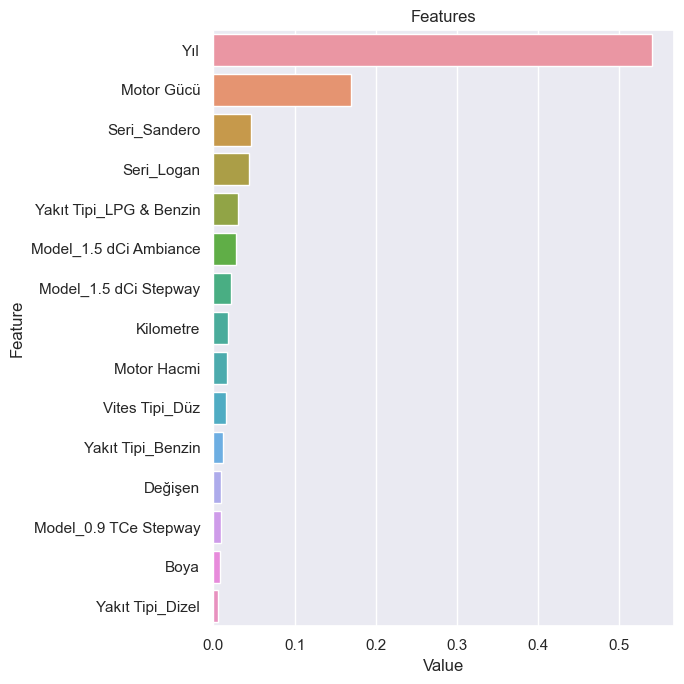

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)